# Emitter Receiver autoencoder model

In [1]:
import warnings; warnings.simplefilter('ignore')

import torch
import random
import os
import time
import itertools
import collections
import torch.nn as nn
import scipy as sp
import umap
import pandas as pd
from cell import graph_utils, utils, math_utils
from IPython.display import Image
from numpy.random import multinomial
from torch.nn import functional as F
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarDiGraph
import cell.BiasedDirectedWeightedWalk as BDWW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from sinkhorn_knopp import sinkhorn_knopp as skp

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import imp
from cell import  utils, analysis, plot_utils, graph_utils
from cell.Word2vec import prepare_vocab, dataloader, wv


imp.reload(utils)
imp.reload(analysis)

imp.reload(prepare_vocab)

<module 'cell.Word2vec.prepare_vocab' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/Word2vec/prepare_vocab.py'>

In [3]:
npp_adj = graph_utils.read_npp_interaction_matrices()
sns.heatmap(npp_adj)

TypeError: read_npp_interaction_matrices() missing 1 required positional argument: 'version'

In [4]:
#Create a dataframe
npp_adj = pd.DataFrame(npp_adj)
npp_adj.index = npp_adj.index.astype(str)
npp_adj.columns = npp_adj.columns.astype(str)

#Find all nodes with zero outgoing edges
index_to_drop = []
for index, row in npp_adj.iterrows():
    if (np.sum(row) == 0):
        index_to_drop.append(index)
        print("row index: ",index, "should be dropped as it has not outgoing edges")

#Drop some rows based on their connections
for ind in index_to_drop:
    npp_adj = npp_adj.drop(ind, axis=0)
    npp_adj = npp_adj.drop(ind, axis=1)

row index:  21 should be dropped as it has not outgoing edges


In [5]:
npp_adj.head()

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.936187,0.768484,0.959233,0.803355,0.924923,0.980995,0.740588,0.987354,0.668763,1.165541,...,0.633823,0.405660,0.326936,0.587962,0.338413,0.532010,0.450015,0.275699,0.599208,0.593314
1,0.790692,0.555642,0.757755,0.577711,0.630822,0.663200,0.462023,0.565815,0.332883,0.774369,...,0.377223,0.212919,0.138344,0.273469,0.125997,0.333608,0.226424,0.112440,0.301754,0.119409
2,0.892147,0.712143,0.921591,0.789601,0.877128,0.870740,0.643997,0.886173,0.590462,1.041684,...,0.571998,0.392207,0.324273,0.604153,0.357973,0.527151,0.449813,0.276949,0.608939,0.558004
3,0.785652,0.687346,0.841630,0.734949,0.798094,0.815856,0.633850,0.917081,0.607991,1.017417,...,0.560358,0.304011,0.274533,0.470036,0.219715,0.496468,0.428310,0.246388,0.470338,0.468221
4,0.471479,0.437232,0.504707,0.444062,0.498042,0.529087,0.427269,0.620584,0.421984,0.662953,...,0.354924,0.193698,0.167763,0.277236,0.129398,0.287891,0.251013,0.147875,0.286385,0.322952


In [134]:
new_npp_adj = graph_utils.Keep_only_k_largest_value_of_each_row(npp_adj, 7)
new_npp_adj.head()

col,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
row,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.165541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.790692,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.774369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.041684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.84163,0.0,0.0,0.000000,0.0,0.917081,0.0,1.017417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.00000,0.0,0.0,0.529087,0.0,0.620584,0.0,0.662953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
%matplotlib qt
fig = plt.figure(figsize=(10,8))
sns.heatmap(new_npp_adj)

In [137]:
row_normal_new_npp_adj = graph_utils.Divide_each_Row_by_colsum(new_npp_adj)
row_normal_new_npp_adj.head()

col,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
row,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.136617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.126495,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.123883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.126019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.133582,0.0,0.0,0.000000,0.0,0.145557,0.0,0.161483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.129941,0.0,0.152412,0.0,0.162818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(row_normal_new_npp_adj)

In [10]:
if(sum(np.sum(row_normal_new_npp_adj, axis=1)==0) == 0):
    print("All the nodes have at least one outoging connection")

All the nodes have at least one outoging connection


# Doubly stochastic normalization

In [11]:
sk = skp.SinkhornKnopp()

In [12]:
npp_adj = graph_utils.read_npp_interaction_matrices()
# add epsilon to all zero values in the adj matrix
npp_adj[npp_adj == 0] = 0.00001
sns.heatmap(npp_adj)

In [13]:
doub_stot_npp_adj = sk.fit(npp_adj)
sns.heatmap(doub_stot_npp_adj)

# Apply double stochastic and then add them together and apply double stochastic again

In [14]:
npp_adj = np.zeros((93, 93))
which_layers = utils.get_npp_visp_layers()

for layer in which_layers:
    path = utils.get_npp_visp_interaction_mat_path(layer)
    tmp_inter = pd.read_csv(path, index_col="Unnamed: 0")
    tmp_inter[tmp_inter == 0] = 0.00001
    tmp_inter = sk.fit(tmp_inter)
    npp_adj = npp_adj + tmp_inter
    
sns.heatmap(npp_adj)

In [15]:
tmp = row_normal_new_npp_adj
tmp[tmp == 0] = 0.00001
tmp = sk.fit(tmp)

In [16]:
sns.heatmap(sk.fit(tmp))

# Add all the channels, keep 7 highest ingoing and 7 highest outgoing, then apply double stochastic

In [377]:
npp_adj = graph_utils.read_npp_interaction_matrices()
npp_adj = pd.DataFrame(npp_adj)
npp_adj.index = npp_adj.index.astype(str)
npp_adj.columns = npp_adj.columns.astype(str)

#Find all nodes with zero outgoing edges
index_to_drop = []
for index, row in npp_adj.iterrows():
    if (np.sum(row) == 0):
        index_to_drop.append(index)
        print("row index: ",index, "should be dropped as it has not outgoing edges")

#Drop some rows based on their connections
for ind in index_to_drop:
    npp_adj = npp_adj.drop(ind, axis=0)
    npp_adj = npp_adj.drop(ind, axis=1)
    
melted = pd.melt(npp_adj.reset_index(), id_vars='index')
melted.columns = ["row", 'col', 'value']
melted["rank_row"] = melted.groupby("row")["value"].rank("dense", ascending=False)
melted["rank_col"] = melted.groupby("col")["value"].rank("dense", ascending=False)
melted['keep'] = np.where((melted['rank_row'] <= 7) | (melted['rank_col'] <= 7), melted['value'], 0.)
new_df = melted.pivot(index='row', columns='col', values='keep')
new_df = new_df.loc[[i for i in npp_adj.index.tolist()]][[i for i in npp_adj.columns.tolist()]]

row index:  21 should be dropped as it has not outgoing edges


In [378]:
sk = skp.SinkhornKnopp()
new_df[new_df == 0] = 0.00001
new_df = sk.fit(new_df)

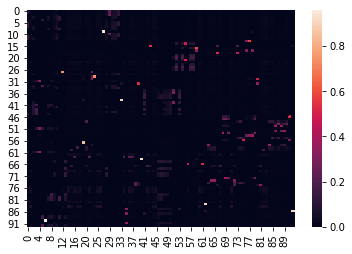

In [397]:
sns.heatmap(new_df)
new_df = pd.DataFrame(new_df)
new_df.index = npp_adj.index.astype(str)
new_df.columns = npp_adj.columns.astype(str)

In [398]:
edges = graph_utils.build_edge_list(weight_matrix=new_df, threshold=None, directed=True)

Building a directed graph edge list


In [402]:
edges = graph_utils.build_edge_list(weight_matrix=new_df, threshold=None, directed=True)
nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=True)

# 2) Create stellar Di graphs
sdg = StellarDiGraph(nxg)
BDWW.BeginWalk(sdg, begin_checks=True, weighted=True, directed=True)
rw = BDWW.BiasedDirectedRandomWalk(sdg, directed=True, weighted=True, begin_checks=False)

nodes = list(sdg.nodes())
walks = rw.run(nodes=nodes, length=100, n=100, p=1, q=1, weighted=True, directed=True)

utils.write_list_of_lists_to_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/walk_double_stochastic_7connections.csv", walks)

In [404]:
prefix = "run_Adcyap1-Adcyap1r1"
finished_epoch = 100 + 100
p = []
for e in range(100, finished_epoch, 100):
    epoch = e
    n_emb = 3

    E = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/" + 
                    prefix + "_" + str(epoch) + "_E_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")
    R = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/" + 
                    prefix + "_" + str(epoch) + "_R_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")

    E.index = E.index.astype(str)
    R.index = R.index.astype(str)

    E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(E[["Z" + str(i) for i in range(n_emb)]], 
                                                                                        R[["Z" + str(i) for i in range(n_emb)]])
    p.append(analysis.Compute_node_average_ndcg(adj=th_subclass_npp, e_to_r=E_to_R_dist, k=7))   

In [788]:
cldf=utils.read_visp_npp_cldf()

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


In [789]:
E.index.name = "cluster_id"
R.index.name = "cluster_id"
E = pd.merge(cldf, E, on ="cluster_id")[['Z0', "Z1", "Z2", "cluster_color", "cluster_label"]]
R = pd.merge(cldf, R, on ="cluster_id")[['Z0', "Z1", "Z2", "cluster_color", "cluster_label"]]

In [790]:
print(np.mean(E))
print(np.mean(R))

Z0    2.571429e-08
Z1    5.000000e-09
Z2   -2.428571e-09
dtype: float64
Z0    0.002253
Z1   -0.000134
Z2    0.000618
dtype: float64


In [792]:
%matplotlib qt5
plot_utils.plot_ER(E, R, (10,10), plot_dim=3, annotation=True,  E_marker='o', R_marker='x', use_type_colors=True)
plt.show()

In [793]:
plt.scatter([i for i in range(100, finished_epoch, 100)],p)
plt.plot([i for i in range(100, finished_epoch, 100)], p)
plt.xlabel("epochs")
plt.ylabel("nandcg@7")

Text(0, 0.5, 'nandcg@7')

In [794]:
%matplotlib qt
ndcg, _ = plot_utils.plot_node_average_ndcg(adj=th_subclass_npp, e_to_r=E_to_R_dist, k=5, figsize=(15,5))

In [5]:
np.log2(0.1+1)

0.13750352374993502

In [760]:
similarity

,8,12,9,7,6,10,1,5,2,14,13,11,4,3
8,0.942988,0.274125,1.06368,0.874333,2.48119,1.08366,0.0294922,0.382751,0,0.777108,0.287647,0.21519,0.312922,0.317302
12,0.304256,1.80364,0.664834,0.133482,0.776925,0.696902,1.72335,2.73714,1.70821,0,2.43565,1.7816,3.04924,3.06481
9,3.08888,0.0672904,2.743,3.23061,0.727653,2.70977,0.00201407,0.181219,0,3.37914,0.170644,0.0573526,0.340062,0.32283
7,3.0866,0.066664,2.74003,3.23063,0.730242,2.70677,0.00191815,0.178536,0,3.38025,0.168577,0.0568737,0.337326,0.320069
6,0.291045,3.2951,0.599506,0.148822,1.03395,0.623404,3.15717,2.48659,3.11751,0,2.81737,3.29783,1.89645,1.90551
10,3.08423,0.0661747,2.73662,3.2306,0.732385,2.70329,0.00184123,0.175436,0,3.3808,0.16628,0.0565079,0.333507,0.316243
1,0.2858,3.07993,0.588699,0.145717,0.817121,0.610624,3.32425,2.39391,3.33229,0,2.74999,3.14755,1.85644,1.86172
5,0.291061,3.25365,0.59991,0.148543,0.996448,0.623709,3.13481,2.46509,3.09614,0,2.80238,3.26829,1.88317,1.89149
2,0.284153,3.03532,0.584355,0.145256,0.781819,0.605778,3.30471,2.34243,3.32997,0,2.69963,3.10616,1.81408,1.81865
14,3.08928,0.0674255,2.74361,3.23022,0.726012,2.71037,0.00203695,0.181843,0,3.37816,0.171164,0.0574571,0.34059,0.323366


In [761]:
similarity = analysis.get_similarity_from_distance_matrix(E_to_R_dist)
predictions = analysis.get_predictions_correct_format_for_precision_recall_function(estimated_relevance=similarity, 
                                                                                    true_relevance=th_subclass_npp)
precisions, recalls, sorted_user_est_true= analysis.precision_recall_at_k(predictions, k=7)

# plot_utils.plot_dict(precisions, "node_ids", "precisions@7", 90, order_of_x_values=new_df.index.tolist())
# plot_utils.plot_dict(recalls, "node_ids", "precisions", 90)

This measure makes sense for when the small weights are set to zero and everything morethan 0.00001 is a relevant weight and almost equal to all other weights


In [785]:
node_id = '5'
tmp = analysis.get_closest_nodes_info(node_id, E_to_R_dist, th_subclass_npp, 5, cldf, "subclass_label")
tmp

Closet neighbors of subclass_label Sst
______________________________________


,predicted_neighbors_weights,predicted_closest_neighbors_index,predicted_closest_neighbors_label,Actual_neighbor_weights,Actual_neighbor_index,Actual_neighbor_label,match
0,0.181898,11,L5 PT,0.196824,1,Lamp5,1
1,0.140942,12,NP,0.181898,11,L5 PT,1
2,0.196824,1,Lamp5,0.140942,12,NP,1
3,0.129124,2,Sncg,0.129124,2,Sncg,1
4,0.116118,13,L6 CT,0.116118,13,L6 CT,1


In [653]:
true_y, predicted_y,_, ndcg = analysis.get_distance_ndcg_score(node_id, E_to_R_dist, th_subclass_npp, 7)
print(ndcg)
print(precisions[node_id])

0.9970636522729049
1.0


In [383]:
# sorted(new_df.loc[node_id], reverse=True)

In [138]:
minvar = utils.read_list_from_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/" + prefix + "_minvar.csv")
mvl0 = utils.read_list_from_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/" + prefix + "_mvl0.csv")
mvl1 = utils.read_list_from_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/" + prefix + "_mvl1.csv")


plt.plot([np.float(mv) for mv in minvar], label="min_svd", c='Blue', linestyle='dashed',alpha=0.75)
plt.plot([np.float(mv) for mv in mvl0], label="svd-dim0", c='Red', alpha=0.5)
plt.plot([np.float(mv) for mv in mvl1], label="svd-dim1", c='Green', alpha=0.5)

plt.xlabel("epochs")
plt.ylabel("svd")
plt.legend()
plt.show()

In [199]:
dist = utils.read_list_from_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/" + prefix + "_mean_d.csv")

plt.plot([np.float(d) for d in dist], label="mean_dist")
plt.show()

In [36]:
dist = utils.read_list_from_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/" + prefix + "_loss.csv")

plt.plot([np.float(d) for d in dist], label="loss")
plt.show()

# Subclass level graph

In [376]:
npp_adj = graph_utils.read_npp_interaction_matrices()
npp_adj = pd.DataFrame(npp_adj)
npp_adj.index = npp_adj.index.astype(str)
npp_adj.columns = npp_adj.columns.astype(str)
npp_adj.index.name = 'cluster_id'


npp_adj = pd.merge(npp_adj, cldf[['subclass_id']], on="cluster_id")
npp_adj = npp_adj.groupby("subclass_id").mean()

npp_adj = npp_adj.T
npp_adj.index.name = "cluster_id"
npp_adj = pd.merge(npp_adj, cldf[['subclass_id']], on="cluster_id")
npp_adj = npp_adj.groupby("subclass_id").mean()
npp_adj = npp_adj.T
npp_adj.index = npp_adj.index.astype(str)
npp_adj.columns = npp_adj.columns.astype(str)

In [377]:
npp_adj

subclass_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,0.691190,1.269353,0.713264,1.317430,0.530921,0.302688,1.020234,1.053363,1.136423,1.045150,0.649073,0.314113,0.665001,0.741349
2,0.593083,1.383845,0.638998,1.376352,0.437578,0.334547,1.434059,1.570507,1.327735,1.124677,0.693525,0.221353,0.721046,1.048185
3,0.644686,1.332554,0.680675,1.346506,0.593786,0.433459,1.505054,1.685983,1.456854,1.211027,0.822971,0.371690,0.807024,1.168458
4,0.587974,0.456030,0.489898,0.849752,1.104440,0.707329,0.925240,1.394830,1.446243,1.234872,0.835101,0.622629,0.817783,1.223660
5,1.579451,1.759144,1.378846,2.356874,1.439514,0.664598,1.531186,1.452457,2.437079,2.787767,1.525554,0.608457,1.675253,1.663001
6,0.862457,0.990023,0.820444,1.326882,0.695740,0.417265,0.925987,0.834540,1.471639,1.557324,0.878453,0.379103,0.991948,0.769852
7,0.213191,0.153508,0.216469,0.311333,0.421482,0.387870,0.810430,0.723556,0.721725,0.731194,0.451919,0.143692,0.547936,1.084959
8,0.275117,0.342033,0.343948,0.335495,0.409689,0.393838,0.771542,0.734949,0.754574,0.761645,0.365253,0.152901,0.464245,0.730457
9,0.152824,0.168860,0.183345,0.184177,0.237044,0.276010,0.672873,0.598875,0.597620,0.602260,0.333146,0.084198,0.417425,0.711090
10,0.168780,0.092948,0.112779,0.169586,0.339428,0.330418,0.743966,0.630550,0.607870,0.601100,0.409166,0.106477,0.501024,1.048989


In [378]:
subclass_npp = npp_adj.copy()
sk = skp.SinkhornKnopp()
subclass_npp[subclass_npp == 0] = 0.00001
subclass_npp = sk.fit(subclass_npp)
subclass_npp = pd.DataFrame(subclass_npp)
subclass_npp.index = npp_adj.index.astype(str)
subclass_npp.columns = npp_adj.columns.astype(str)

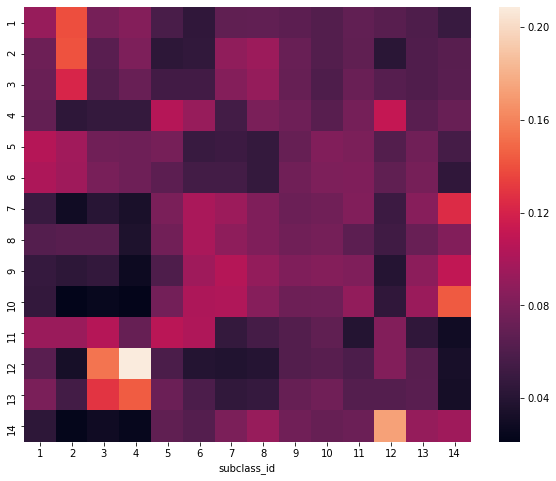

In [380]:
# %matplotlib inline
plt.figure(figsize=(10,8))
sns.heatmap(subclass_npp)

In [558]:
edges = graph_utils.build_edge_list(weight_matrix=subclass_npp, threshold=None, directed=True)
nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=True)

# 2) Create stellar Di graphs
sdg = StellarDiGraph(nxg)
BDWW.BeginWalk(sdg, begin_checks=True, weighted=True, directed=True)
rw = BDWW.BiasedDirectedRandomWalk(sdg, directed=True, weighted=True, begin_checks=False)

nodes = list(sdg.nodes())
walks = rw.run(nodes=nodes, length=100, n=100, p=1, q=1, weighted=True, directed=True)

utils.write_list_of_lists_to_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/walk_double_stochastic_subclass_npp.csv", walks)

Building a directed graph edge list
Checking all the weights on all the edges!
Computing the node importance!
Done writing!


# Subclass level graph with threshold

In [10]:
cldf=utils.read_visp_npp_cldf(version="old")

npp_adj = graph_utils.read_npp_interaction_matrices()
npp_adj = pd.DataFrame(npp_adj)
npp_adj.index = npp_adj.index.astype(str)
npp_adj.columns = npp_adj.columns.astype(str)
npp_adj.index.name = 'cluster_id'


npp_adj = pd.merge(npp_adj, cldf[['subclass_id']], on="cluster_id")
npp_adj = npp_adj.groupby("subclass_id").mean()

npp_adj = npp_adj.T
npp_adj.index.name = "cluster_id"
npp_adj = pd.merge(npp_adj, cldf[['subclass_id']], on="cluster_id")
npp_adj = npp_adj.groupby("subclass_id").mean()
npp_adj = npp_adj.T
npp_adj.index = npp_adj.index.astype(str)
npp_adj.columns = npp_adj.columns.astype(str)

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


### Choose the highest 7 connections

In [12]:
melted = pd.melt(npp_adj.reset_index(), id_vars='index')
melted.columns = ["row", 'col', 'value']
melted["rank_row"] = melted.groupby("row")["value"].rank("dense", ascending=False)
melted["rank_col"] = melted.groupby("col")["value"].rank("dense", ascending=False)
melted['keep'] = np.where((melted['rank_row'] <= 5) | (melted['rank_col'] <= 5), melted['value'], 0.)
melted = melted.pivot(index='row', columns='col', values='keep')
melted = melted.loc[[i for i in npp_adj.index.tolist()]][[i for i in npp_adj.columns.tolist()]]

In [13]:
sk = skp.SinkhornKnopp()
melted[melted == 0] = 0.00001
th_subclass_npp = sk.fit(melted)
th_subclass_npp = pd.DataFrame(th_subclass_npp)
th_subclass_npp.index = npp_adj.index.astype(str)
th_subclass_npp.columns = npp_adj.columns.astype(str)

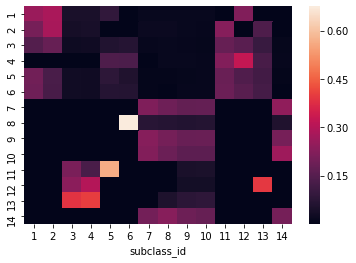

In [14]:
sns.heatmap(th_subclass_npp)

In [18]:
# np.sum(th_subclass_npp, axis=0)

In [17]:
edges = graph_utils.build_edge_list(weight_matrix=th_subclass_npp, threshold=None, directed=True)
nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=True)

# 2) Create stellar Di graphs
sdg = StellarDiGraph(nxg)
BDWW.BeginWalk(sdg, begin_checks=True, weighted=True, directed=True)
rw = BDWW.BiasedDirectedRandomWalk(sdg, directed=True, weighted=True, begin_checks=False)

nodes = list(sdg.nodes())
walks = rw.run(nodes=nodes, length=100, n=100, p=1, q=1, weighted=True, directed=True)

utils.write_list_of_lists_to_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/walk_double_stochastic_th_subclass_npp.csv", walks)

Building a directed graph edge list
Checking all the weights on all the edges!
Computing the node importance!
Done writing!


# Cutting at different height of the tree

In [405]:
from celltype_hierarchy import *

In [407]:
from celltype_hierarchy.analysis_tree_helpers import HTree

ModuleNotFoundError: No module named 'feather'